In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
from torch import nn, device
from torch.nn import functional as F
import zipfile
from torchvision import transforms
import csv
import itertools
import time
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2


In [ ]:
!rm -rf /kaggle/working/*

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [ ]:
def create_image_df(base_dir, text_file_path):
    with open(text_file_path, 'r') as file:   # Read lines from the text file
        lines = file.readlines()

    # Initialize lists to store image file paths and labels
    image_i = []
    image_ii = []
    labels = []
    for line in lines:  # Iterate through each line in the text file
        parts = line.strip().split()
        if len(parts) == 4:  # Two different people
            name1, img1, name2, img2 = parts
            label = 0
        elif len(parts) == 3:  # Same person
            name1, img1, img2 = parts
            name2 = name1
            label = 1
        else:
            continue  # Skip lines with incorrect format

        # Construct the paths to the image files
        zeros_1 = '0' * (4 - len(img1))
        img1_path = os.path.join(base_dir, name1, f"{name1}_{zeros_1}{img1}.jpg")
        zeros_2 = '0' * (4 - len(img2))
        img2_path = os.path.join(base_dir, name2, f"{name2}_{zeros_2}{img2}.jpg")

        image_i.append(img1_path) # Append image file paths and label to the lists
        image_ii.append(img2_path)
        labels.append(label)

    # Create the DataFrame
    df = pd.DataFrame({'image1': image_i,'image2': image_ii,'label': labels })
    return df


In [ ]:
class MyDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform if transform is not None else transforms.Compose([
            transforms.Resize((105, 105)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
        ])
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):          # Retrieve paths to the images and their label from the DataFrame
        # Open and apply transformations to the images
        img1_path = self.df.iloc[idx]['image1']
        img1 = Image.open(img1_path)
        img1 = self.transform(img1)
        img2_path = self.df.iloc[idx]['image2']
        img2 = Image.open(img2_path)
        img2 = self.transform(img2)
        label = torch.tensor(self.df.iloc[idx]['label'])
        label = label.clone().detach().to(torch.float32)
        return img1, img2, label

In [ ]:
train_df = create_image_df('/kaggle/input/my-data/lfwa/lfw2/lfw2', '/kaggle/input/my-data/pairsDevTrain.txt')
test_df = create_image_df('/kaggle/input/my-data/lfwa/lfw2/lfw2', '/kaggle/input/my-data/pairsDevTest.txt')
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])
train_dataset = MyDataset(train_df)
val_dataset = MyDataset(val_df)
test_dataset = MyDataset(test_df)


# Analysis of the dataset

In [ ]:
def add_bar_labels(ax):
    for rect in ax.patches:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom')


# Subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Sizes of train, validation, and test sets
sns.barplot(x=['Train', 'Validation', 'Test'], y=[len(train_dataset), len(val_dataset), len(test_dataset)], ax=axes[0, 0])
axes[0, 0].set_title('Size of Datasets')
add_bar_labels(axes[0, 0])

# Number of examples per class in train
sns.barplot(x=train_df['label'].value_counts().index, y=train_df['label'].value_counts().values, ax=axes[0, 1])
axes[0, 1].set_title('Number of Examples per Class in the Train data')
add_bar_labels(axes[0, 1])

# Plot number of examples per class in validation
sns.barplot(x=val_df['label'].value_counts().index, y=val_df['label'].value_counts().values, ax=axes[1, 0])
axes[1, 0].set_title('Number of Examples per Class in the Validation data')
add_bar_labels(axes[1, 0])

# Plot number of examples per class in test
sns.barplot(x=test_df['label'].value_counts().index, y=test_df['label'].value_counts().values, ax=axes[1, 1])
axes[1, 1].set_title('Number of Examples per Class in the Test data')
add_bar_labels(axes[1, 1])

plt.tight_layout()
plt.show()

In [ ]:
def display_images(image_paths, label):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for i, path in enumerate(image_paths):     # Iterate over the image paths and display each image
        image = mpimg.imread(path)
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
    fig.suptitle(f"Label: {label}", fontsize=16)     # Set a title indicating the label
    plt.show()

# Examples with label 0
for idx, row in train_df[train_df['label'] == 0].head(2).iterrows():
    display_images([row['image1'], row['image2']], row['label'])

# Examples with label 1
for idx, row in train_df[train_df['label'] == 1].head(2).iterrows():
    display_images([row['image1'], row['image2']], row['label'])


In [ ]:
faces_dict = {}
for index, row in test_df.iterrows():
    image1 = row['image1'].split('/')[-1]
    image2 = row['image2'].split('/')[-1]
    name1 = image1[:-9]
    name2 = image2[:-9]
    if name1 not in faces_dict.keys():
        faces_dict[name1] = []
    if name2 not in faces_dict.keys():
        faces_dict[name2] = []
    faces_dict[name1].append(image1)
    faces_dict[name2].append(image2)
faces_dict= {key: len(value) for key, value in faces_dict.items()}
num_photos = list(faces_dict.values())
# Plotting histogram
plt.hist(num_photos, bins=10, color='skyblue', edgecolor='black')

plt.xlabel('Number of Photos')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Photos per Person')
plt.grid(True)

plt.show()

creating the netwrok

In [ ]:
import torch.nn.functional as F

class SiameseNetwork(nn.Module):
    def __init__(self, use_batchnorm=False, use_dropout=False, dropout_prob=0.5):
        """
        Initialize the Siamese Network.

        Args:
        use_batchnorm : Flag to indicate if to use batch normalization.
        use_dropout : Flag to indicate if to use dropout.
        dropout_prob : Dropout probability.
        """
        super(SiameseNetwork, self).__init__()
        self.use_batchnorm = use_batchnorm
        self.use_dropout = use_dropout
        self.dropout_prob = dropout_prob

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(10, 10), stride=(1, 1), padding='valid')
        if self.use_batchnorm:
            self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(7, 7), stride=(1, 1), padding='valid')
        if self.use_batchnorm:
            self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(4, 4), stride=(1, 1), padding='valid')
        if self.use_batchnorm:
            self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(4, 4), stride=(1, 1), padding='valid')
        if self.use_batchnorm:
            self.bn4 = nn.BatchNorm2d(256)

        # Max pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        if self.use_batchnorm:
            self.bn_fc1 = nn.BatchNorm1d(4096)
        if self.use_dropout:
            self.dropout_fc1 = nn.Dropout(p=self.dropout_prob)
        self.fc2 = nn.Linear(4096, 1)

    def forward_single_image(self, x):
        """
        Forward pass for a single image.

        Args:
        x (torch.Tensor): Input image tensor.

        Returns:
        torch.Tensor: Output tensor.
        """
        x = F.relu(self.conv1(x))
        if self.use_batchnorm:
            x = self.bn1(x)
        x = self.maxpool(x)

        x = F.relu(self.conv2(x))
        if self.use_batchnorm:
            x = self.bn2(x)
        x = self.maxpool(x)

        x = F.relu(self.conv3(x))
        if self.use_batchnorm:
            x = self.bn3(x)
        x = self.maxpool(x)

        x = F.relu(self.conv4(x))
        if self.use_batchnorm:
            x = self.bn4(x)

        # Flatten before fully connected layers
        x = torch.flatten(x, start_dim=1)

        x = torch.sigmoid(self.fc1(x))
        if self.use_batchnorm:
            x = self.bn_fc1(x)
        if self.use_dropout:
            x = self.dropout_fc1(x)
        return x

    def forward(self, x1, x2):
        """
        Forward pass for the Siamese network.

        Args:
        x1 (torch.Tensor): Input tensor for image 1.
        x2 (torch.Tensor): Input tensor for image 2.

        Returns:
        torch.Tensor: Output logits.
        """
        img1 = self.forward_single_image(x1)
        img2 = self.forward_single_image(x2)
        L1_simanese_dist = torch.abs(img1 - img2)
        logits = torch.sigmoid(self.fc2(L1_simanese_dist))
        return logits


In [ ]:
##initialize weights and biases
def init_w_and_b(m):
  """
  Initializes the weights and biases of a neural network layer.
  param m: The neural network module or layer to initialize.
  """

  if type(m) == nn.Conv2d:
    nn.init.normal_(m.weight, mean=0, std=0.01)
    nn.init.normal_(m.bias, mean=0.5, std=0.01)

In [ ]:
def calculate_accuracy(model, dataloader, threshold=0.5):
    """
    Calculate the accuracy of the model on a given dataloader.
    model : The trained Siamese network model.
    dataloader: DataLoader for the dataset.
    threshold: The threshold to decide between classes.

    Returns:
    accuracy: The accuracy of the model on the dataset.
    """
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            img1, img2, labels = data ## get items
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device) ##save to device
            outputs = model.forward(img1, img2)
            predicted = (outputs > threshold).float() # binary predictions
            total += labels.size(0)#all
            current = predicted == labels
            # Extracting the diagonal elements
            diagonal = torch.diag(current)
            # Counting True values
            correct += diagonal.sum().item()

    accuracy = correct / total
    return accuracy

In [ ]:
def train_validation(model, train_dataloader, val_dataloader, loss_fn, optimizer, num_epochs=30, batch_size=8, threshold=0.5, early_stopping=5):
    """
    Train and validation

    Parameters:
    model : The Siamese network model.
    train_dataloader : DataLoader of training data.
    val_dataloader : DataLoader of validation data.
    loss_fn : Loss function.
    optimizer: Optimizer for training.
    num_epochs : Number of epochs for training.
    batch_size : Batch size.
    threshold : Threshold to decide between classes.
    early_stopping:epochs to wait for improvement in val loss before early stopping.

    outputs: 4 lists - training losses, training accuracies, validation losses, and validation accuracies
    """
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_train_loss = 0
        for data in train_dataloader:
            img1, img2, labels = data ##get items
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)##save for device

            outputs = model(img1, img2)
            loss = loss_fn(outputs.squeeze(), labels.squeeze())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        train_accuracy = calculate_accuracy(model, train_dataloader)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        total_val_loss = 0
        for data in val_dataloader:
            img1, img2, labels = data##get items
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)##save for device
            outputs = model(img1, img2)
            loss = loss_fn(outputs.squeeze(), labels.squeeze())
            total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        val_accuracy = calculate_accuracy(model, val_dataloader)
        val_accuracies.append(val_accuracy)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= early_stopping:
            break

    return train_losses, train_accuracies, val_losses, val_accuracies



In [ ]:
##save result in csv
def save_result(data):
    results = 'results.csv'
    if not os.path.exists(results):  # if the file does not exist -> create it
        with open(results, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['experiment_number', 'number_of_epochs', 'batch_size', 'learning_rate', 'batchnorm','dropout', 'train_loss', 'train_accuracy', 'validation_loss', 'validation_accuracy'])
    df = pd.DataFrame([data], columns=['experiment_number', 'number_of_epochs', 'batch_size', 'learning_rate', 'batchnorm','dropout', 'train_loss', 'train_accuracy', 'validation_loss', 'validation_accuracy'])
    df.to_csv(results, mode='a', index=False, header=False)

**check basic network with and without batchnorm and dropout**

In [ ]:
batch_size = 8
epochs= 30
lr = 1e-3
loss_fn =  nn.BCELoss()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
i = 0
for use_batchnorm, use_dropout  in itertools.product([True,False],[True,False]):
    i+=1
    model = SiameseNetwork(use_batchnorm, use_dropout).to(device)
    model.apply(init_w_and_b)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    train_losses, train_accuracies, val_losses, val_accuracies = train_validation(model, train_loader , val_loader, loss_fn, optimizer,epochs,batch_size)
    save_result([i, epochs,batch_size, lr,use_batchnorm,use_dropout, train_losses[-1],  train_accuracies[-1],val_losses[-1],val_accuracies[-1]])
    print([i, epochs,batch_size, lr, use_batchnorm,use_dropout, train_losses[-1],  train_accuracies[-1],val_losses[-1],val_accuracies[-1]])

Now, that we found out that the batchnorm improve the accuracy on the validation and the of dropout casued lower accuracy on the validation,
we will try to check the netwrok with batchnorm and without dropout on different combination on hyperparameter

In [ ]:
def grid_search(optimizer_list, loss_fn_list,batch_size_list, lrs_list, early_stopping=5):
    """
    Perform a grid search over hyperparameters to find the optimal configuration.

    Parameters:
        optimizer_list (list): List of optimizer names ('Adam', 'SGD').
        loss_fn_list (list): List of loss function names ('BCELoss', 'MSELoss').
        batch_size_list (list): List of batch sizes.
        lrs_list (list): List of learning rates.
        early_stopping (int): Number of epochs to wait for improvement in validation loss before early stopping. Default is 5.

    Returns:
        list: A list of dictionaries containing results for each hyperparameter combination.
            Each dictionary includes information such as optimizer, loss function, batch size, learning rate,
            training and validation losses, accuracies, convergence time, and whether early stopping occurred.
    """
    results =[]
    epochs = 30
    for optimizer, loss_fn, batch_size, lr in itertools.product(optimizer_list, loss_fn_list, batch_size_list, lrs_list):
        use_batchnorm = True
        use_dropout= False
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
        model = SiameseNetwork(use_batchnorm, use_dropout).to(device)
        model.apply(init_w_and_b)

        # Set optimizer
        if optimizer == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        elif optimizer == 'SGD':
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

        # Set loss function
        if loss_fn == 'BCELoss':
            loss_fn = nn.BCELoss()
        elif loss_fn == 'MSELoss':
            loss_fn = nn.MSELoss()

        # Train and validate
        start_time = time.time()
        train_losses, train_accuracies, val_losses, val_accuracies = train_validation(model, train_loader, val_loader, loss_fn, optimizer, epochs, batch_size, early_stopping=3)
        end_time = time.time()
        convergence_time = end_time - start_time
        early_stopping_epochs = len(train_losses)
        early_stopping = early_stopping_epochs < epochs

        # Save results
        result = {
            'optimizer': optimizer.__class__.__name__,
            'loss_fn': loss_fn.__class__.__name__,
            'epochs': epochs if not early_stopping else early_stopping_epochs,
            'early_stopping': early_stopping,
            'batch_size': batch_size,
            'lr': lr,
            'train_losses': train_losses[-1],
            'train_accuracy': train_accuracies[-1],
            'val_losses': val_losses[-1],
            'val_accuracy': val_accuracies[-1],
            'convergence_time': convergence_time
        }
        results.append(result)
        print(result)

    return results

In [ ]:
# Define lists of parameters for grid search
optimizer_list = ['Adam', 'SGD']
loss_fn_list = ['BCELoss', 'MSELoss']
batch_size_list = [8, 16]
lrs_list= [1e-4, 1e-5, 1e-3]


# Perform grid search
grid_results = grid_search(optimizer_list, loss_fn_list, batch_size_list,lrs_list)

def save_results_to_csv(results, filename):
    with open(filename, 'w', newline='') as csvfile:
        fieldnames = results[0].keys()
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for result in results:
            writer.writerow(result)

save_results_to_csv(grid_results, 'grid_search_results.csv')

In [ ]:
def test_model(model, test_dataloader, loss_fn, threshold=0.5):
    """
    Test the model.

    Parameters:
    model : The trained model.
    test_dataloader: Dataloader containing test data.
    loss_fn: Loss function.
    threshold : Threshold to decide between classes.

    Returns:
    test_loss: The average test loss.
    test_accuracy: The test accuracy.
    """
    model.eval()
    total_loss = 0
    correct_indices = []
    incorrect_indices = []

    with torch.no_grad():
        for batch_idx, data in enumerate(test_dataloader):
            img1, img2, labels = data
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            outputs = model(img1, img2)
            loss = loss_fn(outputs.squeeze(), labels.squeeze())
            total_loss += loss.item()

    test_loss = total_loss / len(test_dataloader)
    test_accuracy = calculate_accuracy(model, test_dataloader)

    return test_loss, test_accuracy


In [ ]:
sorted_results = sorted(grid_results, key=lambda x: x['val_accuracy'], reverse=True)
best_params = sorted_results[0]
print(best_params)
optimizer,loss_fn,epochs,batch_size,lr = best_params['optimizer'],best_params['loss_fn'],best_params['epochs'],best_params['batch_size'],best_params['lr']




**According to the chosen parameters**

In [ ]:
# The chosen parameters
batch_size = 16
epochs = 30
lr = 0.0001
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

# Train the model based on the chosen parameters
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, shuffle=True)
model = SiameseNetwork(True, False).to(device)
model.apply(init_w_and_b)
start_time = time.time()
train_losses, train_accuracies, val_losses, val_accuracies = train_validation(model, train_loader , val_loader, loss_fn, optimizer,epochs,batch_size)
end_time = time.time()-start_time
test_loss, test_accuracy= test_model(model,test_loader,loss_fn)

In [ ]:
# The loss of the validation set
val_losses[-1]

In [ ]:
# The accuracy of the validation set
val_accuracies[-1]

In [ ]:
print('convergence time : '+str(end_time))
print('test loss : '+str(test_loss))
print('test accuracy : '+str(test_accuracy))

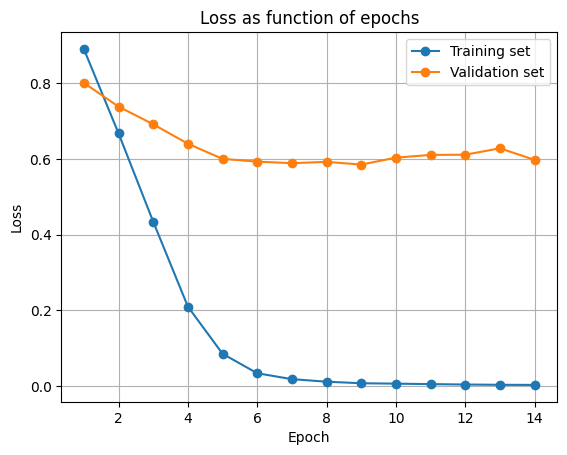

In [ ]:
# Plotting the training and validation losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training set', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation set', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss as function of epochs')
plt.legend()
plt.grid(True)
plt.show()

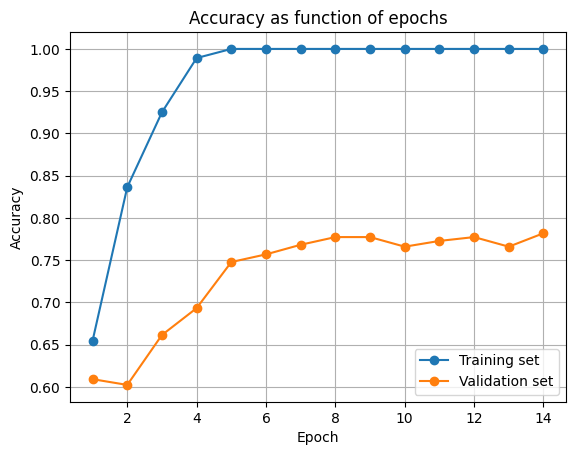

In [ ]:
# Plotting the training and validation accuracies
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training set', marker='o')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation set', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy as function of epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def predict(batch, model):
    """
    Make predictions on a batch using the given model.

    Parameters:
        batch (tuple): A tuple containing image pairs and labels.
        model (SiameseNetwork): The Siamese network model.

    Returns:
        tuple: predicted label, True/False if (pred_label == label), and predicted probability.
    """
    img_1, img_2, label = batch
    img_1 = img_1.to(device)
    img_2 = img_2.to(device)
    label = label.view(-1, 1).to(device)
    prob = model(img_1, img_2)
    pred_label = prob.round()
    prob = prob.tolist()

    return pred_label.tolist(), (pred_label == label).tolist(), prob[0][0]

correct_predictions = []
misclassified_predictions = []
correct_count = 0
misclassified_count = 0
for i, pair in enumerate(test_loader):  # Iterate through the test loader
    predicted_labels, is_accurate, prob = predict(pair, model)
    for j, pred in enumerate(is_accurate):
        pred = pred[0]
        if pred == True: # Correct prediction
            correct_predictions.append((i * test_loader.batch_size + j, prob))
            correct_count += 1
        else:  # Misclassified prediction
            misclassified_predictions.append((i * test_loader.batch_size + j, predicted_labels[j], prob))
            misclassified_count += 1
        break



In [ ]:
# sort the lists based on the probabilities values
correct_predictions = sorted(correct_predictions, key=lambda x: x[1], reverse=True)
misclassified_predictions = sorted(misclassified_predictions, key=lambda x: x[2], reverse=True)

In [ ]:
# Examples with accurate predictions
print("Accurate Predictions:")
for index in correct_predictions[:3]:
    index,prob = index
    img_1_path = test_df.loc[index, 'image1']
    img_2_path = test_df.loc[index, 'image2']
    label = test_df.loc[index, 'label']
    print("The probability: ",prob)
    display_images([img_1_path, img_2_path], label)


for index in correct_predictions[-2:]:
    index,prob = index
    img_1_path = test_df.loc[index, 'image1']
    img_2_path = test_df.loc[index, 'image2']
    label = test_df.loc[index, 'label']
    print("The probability: ",prob)
    display_images([img_1_path, img_2_path], label)

In [ ]:
# Examples with misclassified predictions
print("Misclassified Predictions:")
for index in misclassified_predictions[:2]:
    index,pred_label,prob=index
    img_1_path = test_df.loc[index, 'image1']
    img_2_path = test_df.loc[index, 'image2']
    label = int(pred_label[0])
    print("The probability: ",prob)
    display_images([img_1_path, img_2_path], label)


for index in misclassified_predictions[-2:]:
    index,pred_label,prob=index
    img_1_path = test_df.loc[index, 'image1']
    img_2_path = test_df.loc[index, 'image2']
    label = int(pred_label[0])
    print("The probability: ",prob)
    display_images([img_1_path, img_2_path], label)


# **Visualizations:**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Droupout = True
experiment_number = [1, 2, 3, 4]
batchnorm = [True, True, False, False]
dropout = [True, False, True, False]
train_accuracy = [0.55, 0.69, 0.47, 0.504]
validation_accuracy = [0.53, 0.64, 0.47, 0.509]

# Filter data where dropout is True
dropout_true_indices = [i for i, value in enumerate(dropout) if value]

filtered_experiment_number = [experiment_number[i] for i in dropout_true_indices]
filtered_batchnorm = [batchnorm[i] for i in dropout_true_indices]
filtered_train_accuracy = [train_accuracy[i] for i in dropout_true_indices]
filtered_validation_accuracy = [validation_accuracy[i] for i in dropout_true_indices]

bar_width = 0.35

plt.figure(figsize=(10, 6))

bar_positions_train = np.arange(len(filtered_experiment_number))
bar_positions_validation = bar_positions_train + bar_width

# Create bar plot
plt.bar(bar_positions_train, filtered_train_accuracy, width=bar_width, label='Train Accuracy', color='orange')
plt.bar(bar_positions_validation, filtered_validation_accuracy, width=bar_width, label='Validation Accuracy', alpha=0.7, color='blue')


for i, batchnorm_status in enumerate(filtered_batchnorm):
    plt.text(bar_positions_train[i] + bar_width / 2, -0.05,
             f'Batchnorm={batchnorm_status}', ha='center', va='bottom', color='red')

# Display accuracy values above the bars in the middle
for i, val in enumerate(filtered_train_accuracy):
    plt.text(bar_positions_train[i] + bar_width / 2, val + 0.02, f'Train={val:.3f}', ha='right', va='bottom', color='black')
for i, val in enumerate(filtered_validation_accuracy):
    plt.text(bar_positions_validation[i] + bar_width / 2, val + 0.02, f'Validation={val:.3f}', ha='right', va='bottom', color='black')

plt.xlabel('Batchnorm Status')
plt.ylabel('Accuracy')
plt.title('Accuracy for Experiments with Dropout=True')
plt.xticks([])

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

plt.show()

In [ ]:

experiment_number = [1, 2, 3, 4]
batchnorm = [True, True, False, False]
dropout = [True, False, True, False]
train_accuracy = [0.55, 0.69, 0.47, 0.504]
validation_accuracy = [0.53, 0.64, 0.47, 0.509]

#Dropout = False
dropout_false_indices = [i for i, value in enumerate(dropout) if not value]


filtered_experiment_number = [experiment_number[i] for i in dropout_false_indices]
filtered_batchnorm = [batchnorm[i] for i in dropout_false_indices]
filtered_train_accuracy = [train_accuracy[i] for i in dropout_false_indices]
filtered_validation_accuracy = [validation_accuracy[i] for i in dropout_false_indices]


bar_width = 0.35

plt.figure(figsize=(10, 6))

bar_positions_train = np.arange(len(filtered_experiment_number))
bar_positions_validation = bar_positions_train + bar_width

plt.bar(bar_positions_train, filtered_train_accuracy, width=bar_width, label='Train Accuracy', color='orange')
plt.bar(bar_positions_validation, filtered_validation_accuracy, width=bar_width, label='Validation Accuracy', alpha=0.7, color='blue')

for i, batchnorm_status in enumerate(filtered_batchnorm):
    plt.text(bar_positions_train[i] + bar_width / 2, -0.05,
             f'Batchnorm={batchnorm_status}', ha='center', va='bottom', color='red')

for i, val in enumerate(filtered_train_accuracy):
    plt.text(bar_positions_train[i] + bar_width / 2, val + 0.02, f'Train={val:.3f}', ha='right', va='bottom', color='black')
for i, val in enumerate(filtered_validation_accuracy):
    plt.text(bar_positions_validation[i] + bar_width / 2, val + 0.02, f'Validation={val:.3f}', ha='right', va='bottom', color='black')

plt.xlabel('Batchnorm Status')
plt.ylabel('Accuracy')
plt.title('Accuracy for Experiments with Dropout=False')
plt.xticks([])

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

plt.show()

In [ ]:

#learning rates and batch sizes
batch_sizes = [8, 8, 8, 16, 16, 16]
learning_rates = [0.001, 0.0001, 0.00001]
val_accuracies_8 = [0.584, 0.713, 0.74]
val_accuracies_16 = [0.572, 0.768, 0.734]

# Map batch sizes to colors
color_dict = {8: 'blue', 16: 'orange'}

plt.figure(figsize=(10, 6))

bar_width = 0.35
bar_positions = np.arange(len(learning_rates))

# Plot bars for batch size 8
plt.bar(
    bar_positions - bar_width / 2,
    val_accuracies_8,
    width=bar_width,
    color=[color_dict[8] for _ in val_accuracies_8],
    label='Batch Size: 8',
    alpha=0.7
)

# Plot bars for batch size 16
plt.bar(
    bar_positions + bar_width / 2,
    val_accuracies_16,
    width=bar_width,
    color=[color_dict[16] for _ in val_accuracies_16],
    label='Batch Size: 16',
    alpha=0.7
)

for i, val in enumerate(val_accuracies_8):
    plt.text(
        bar_positions[i] - bar_width / 2,
        val + 0.02,
        f'{val:.3f}',
        ha='center',
        va='bottom',
        color='black'
    )

for i, val in enumerate(val_accuracies_16):
    plt.text(
        bar_positions[i] + bar_width / 2,
        val + 0.02,
        f'{val:.3f}',
        ha='center',
        va='bottom',
        color='black'
    )

plt.title('Validation Accuracy Comparison for Different Learning Rates and Batch Sizes')
plt.xlabel('Learning Rates')
plt.ylabel('Accuracy')
plt.xticks(bar_positions, [f'{lr:g}' for lr in learning_rates])

legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Batch Size: {bs}') for bs, color in color_dict.items()]
plt.legend(handles=legend_labels)

plt.show()

In [ ]:
#Oprimziers and Loss fucntions
val_accuracies_adam_bce = 0.768
val_accuracies_adam_mse = 0.711
val_accuracies_sgd_bce = 0.734
val_accuracies_sgd_mse = 0.752


plt.figure(figsize=(8, 5))

bar_width = 0.35
index = np.arange(2)

# Bar plot for ADAM
adam_bars = plt.bar(index, [val_accuracies_adam_bce, val_accuracies_adam_mse], width=bar_width, label='ADAM', color='blue',alpha=0.7)

# Bar plot for SGD
sgd_bars = plt.bar(index + bar_width, [val_accuracies_sgd_bce, val_accuracies_sgd_mse], width=bar_width, label='SGD', color='orange')

# Set X-axis labels
plt.xticks(index + bar_width / 2, ['BCELoss', 'MSELoss'])

for bar in adam_bars:
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.01, f'{bar.get_height():.3f}', ha='left', va='bottom', color='black')

for bar in sgd_bars:
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.01, f'{bar.get_height():.3f}', ha='left', va='bottom', color='black')

plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.show()